# XGBOOST

This notebook provide an explanation from scratch and user guide for Extreme Gradient Boosting, one of the most implementations of Graadient Boosting. XGboost is an optimized gradient-boosting machine learning library, originally written in C++, that has APIs in several languages: Python, R, Scala, Julia and Java. XGBoost is that popular because of speed and performance. Unlike other Gradient Boosting implementations, XGBoost is parallelizable, what allows train large datasets and as ensemble method it consistently outperforms single-algorithm methods.

In order to understand this implementation, we are going to revise Decision Trees and Boosting and therefore get into XGBoost. 

## Decision Trees

The goal of decision trees is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 

Starting from a node that contain all data (root), decision rules (binary questions) split the data -using axis orthogonal hyperplanes- into two subsets. One of these subsets is a leaf node (corresponds to a class label). The other becomes an internal node where the next decision rule is applied (i.e. at each internal node we test a value of a feature). This strategy is applied till all nodes are leafs or the algorithm is early-stopped.  

In [9]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.researchgate.net/profile/Friedhelm_Schwenker/publication/220361040/figure/fig1/AS:305421668634641@1449829608685/Fig-1-A-binary-decision-tree-of-depth-4-with-two-features-denoted-by-x-and-y-is.png")

Very intuitive, isn`t it? However, the following two questions may appear:

- Which features we should consider as decision rules? Which threshold we should apply? At which level we apply each decision rule?

    There are many different splitting criteria. The most common ones are:
    - Misclassification error: select the split that corrects more data at each point.
    - Gini impurity: probabilistically model the notion of impurity of a node. $\textit{Gini}: \mathit{Gini}(E) = 1 - \sum_{j=1}^{c}p_j^2$
    - Cross-entropy/Information gain/Mutual information: probabilistically model the notion of impurity of a node. $\textit{Entropy}: H(E) = -\sum_{j=1}^{c}p_j\log p_j$
    *Note: Gini impurity and Cross-entropy are more or less the same (same result). They are interchangeable.*  


- If we let the tree grow till the end, the training data is perfectly classified, which means overfitting. How do we deal with this fact?

    There are two ways of avoiding overfitting in trees:
    - Stop growing the tree when the split is not statistically significant (stopping criterion).
    - Grow a full tree and post-prune.

XGBoost uses a special type of trees called CART (Classification and Regression Trees). In spite of leaf containing decision values, in CART each leaf always contains a real-valued score. The main advantage is that they allow to deal both classification and regression tasks.

#### Decision Trees Classification example

In [84]:
churn = pd.read_csv("churn.csv")

## preprocessing 
# We don't need these columns
to_drop = ['State','Area Code','Phone','Churn?']
churn_data = churn.drop(to_drop,axis=1)

# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
yes_no_cols = ["Int'l Plan","VMail Plan"]
churn_data[yes_no_cols] = churn_data[yes_no_cols] == 'yes'

# Pull out features for future use
features = churn_data.columns

X = churn_data.as_matrix().astype(np.float)
y = np.where(churn['Churn?']=="True.", 1,0)

Xy = pd.DataFrame(X)
Xy.columns = churn_data.columns
Xy["y"] = y
Xy.head()

,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,y
0,128.0,0.0,1.0,25.0,265.1,110.0,45.07,197.4,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1.0,0
1,107.0,0.0,1.0,26.0,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1.0,0
2,137.0,0.0,0.0,0.0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0.0,0
3,84.0,1.0,0.0,0.0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2.0,0
4,75.0,1.0,0.0,0.0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3.0,0


In [81]:
# Import the necessary modules
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 

# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Instantiate the classifier: 
dt_clf = DecisionTreeClassifier(max_depth = 3)

# Fit the classifier to the training set
dt_clf.fit(X_train,  y_train)

# Predict the labels of the test set:
y_pred = dt_clf.predict(X_test)

# Compute the accuracy of the predictions: accuracy
accuracy = float(np.sum(y_pred_4==y_test))/y_test.shape[0]
print("accuracy:", accuracy)

accuracy: 0.9016786570743405


#### Decision Trees Regression Example

In [59]:
housing_data = pd.read_csv("BostonHousing.csv")
housing_data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [82]:
# Import the necessary modules
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_squared_error

X = housing_data.drop("medv",axis=1)
y = housing_data["medv"]

# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Instantiate the classifier: dt_clf_4
dt_reg = DecisionTreeRegressor(max_depth = 3)

# Fit the classifier to the training set
dt_reg.fit(X_train,  y_train)

# Predict the labels of the test set: y_pred_4
dt_reg = dt_reg.predict(X_test)

# Compute the accuracy of the predictions: accuracy
rmse = mean_squared_error(dt_reg, y_test)
print("RMSE:", rmse)

RMSE: 40.4345069189


## Boosting

Boosting is a meta-algorithm (a concept that can be applied to a set of machine learning models) used to convert many weak learners into a strong learner.

Boosting is a stage-wise additive modelling. Starts without a classifier and a first weak classifier is fit to the data. Another weak classifier is fitted to improve the current model performance, without changing the past classifiers and so on. This new classifier has to take into account where the pasts classifiers are not performing well. Given the previous classifiers, the next classifier is the one that decreases the most the objective function.

In general terms boosting could be understood as: given a loss function, a response variable and a current model, at each state $t$ figure out the best improvement to the current model with another classifier and update the model with this classifier. This update can be regularized before it is added.

## XGBoost

The idea is iteratively learning a set of weak models on subsets of the data, weighing each weak prediction according to each weak learner's performance, and combining the weighted predictions to obtain a single weighted prediction that is much better than the individual predictions themselves.

Base Learners in XGBoost
- Linear Base Learner (rarely used):
    - Sum of linear terms
    - Boosted model is weighted sum of linear models (thus is itself linear)
- Tree Base Learner:
    - Decision tree
    - Boosted model is weighted sum of decision trees (nonlinear)
    - Almost exclusively used in XGBoost

Loss function names in xgboost:
- reg:linear - use for regression problems
- reg:logistic - use for classification problems when you want just decision, not probability
- binary:logistic - use when you want probability rather than just decision

Regularization parameters in XGBoost:
- gamma - minimum loss reduction allowed for a split to occur
- alpha - l1 regularization on leaf weights, larger values mean more regularization
- lambda - l2 regularization on leaf weights

When to use XGBoost:  
- Practicable to any supervised task. You have a mixture of categorical and numeric features or just numeric features
- You have a large number of training samples. When the number of training samples is large with respect to number of features 

When to NOT use XGBoost:  
- Image recognition
- Computer vision
- Natural language processing and understanding problems

In [153]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

### XGBoost Classification

In [123]:
# Create data
X = churn_data.as_matrix().astype(np.float)
y = np.where(churn['Churn?']=="True.", 1,0)

# Create the training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.25, random_state=123)

# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123, max_depth = 3)

# Fit the classifier to the training set
xg_cl.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_cl.predict(X_test)

# Compute the accuracy: accuracy
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

accuracy: 0.907674


### XGBoost Regression

In [143]:
# Import the necessary modules
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_squared_error

X = housing_data.drop("medv",axis=1)
y = housing_data["medv"]

# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Instantiate the classifier: dt_clf_4
xg_reg = xgb.XGBRegressor(objective='reg:linear', n_estimators=10, seed=123, max_depth = 3)

# Fit the classifier to the training set
xg_reg.fit(X_train,  y_train)

# Predict the labels of the test set: y_pred_4
preds = xg_reg.predict(X_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 9.565767


### Understanding the black box

**Feature importance**

A benefit of using gradient boosting is that after the boosted trees are constructed, it is relatively straightforward to retrieve importance scores for each attribute.

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.

In [146]:
xgb.plot_importance(xg_reg)

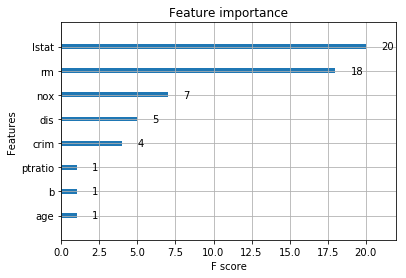

In [147]:
plt.show()

### Optimizing XGBoost Hyperparameters

Hyperparameters:
- tree tunable parameters:
    - learning rate: learning rate/eta
    - gamma: min loss reduction to create new tree split
    - lambda: L2 reg on leaf weights
    - alpha: L1 reg on leaf weights
    - max_depth: max depth per tree
    - subsample: % samples used per tree
    - colsample_bytree: % features used per tree
    - number of boosting rounds
- linear classifier:
    - lambda: L2 reg on weights
    - alpha: L1 reg on weights
    - lambda_bias: L2 reg term on bias
    - number of boosting rounds

#### Grid-search
Search exhaustively over a given set of hyperparameters, once per set of hyperparameters

In [164]:
# Create the parameter grid: gbm_param_grid
gbm_param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'n_estimators': [50],
    'max_depth': [2, 5],
    'learning_rate': [0.01, 0.1, 1]
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor()

# Perform grid search: grid_mse
grid_mse = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid,
                        scoring='neg_mean_squared_error', cv=4, verbose=1)
grid_mse.fit(X, y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Lowest RMSE found:  4.67750914409


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    2.4s finished


#### Random Search
Create a range of hyperparameter values per hyperparameter that you would like to search over and set the number of combinations you would like for the random search to continue.

In [162]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [163]:
# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'learning_rate': np.arange(0.05,1.05,.05),
    'n_estimators': [25],
    'max_depth': range(2, 12)
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor()

# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid, scoring = "neg_mean_squared_error",
                                    n_iter = 10, cv = 4)

# Fit randomized_mse to the data
randomized_mse.fit(X, y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Best parameters found:  {'n_estimators': 25, 'max_depth': 3, 'learning_rate': 0.35000000000000003}
Lowest RMSE found:  4.45482879543
